In [1]:
from CO2xSWV import fetch_data_from_NEON_API, make_df
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import multiprocessing
from dataclasses import dataclass
import xarray as xr
import scipy.stats as stats

from dask import delayed
import dask
from dask.diagnostics import ProgressBar

multiprocessing.cpu_count()

16

```fetch_data``` is commment out bc the files were already downloaded while i was working on this

In [14]:
sitecodes = ['BART', 'ABBY', 'TEAK']
productcodes = ['DP1.00095.001', 'DP1.00094.001','DP1.00041.001']
daterange = ['2015-01', '2020-11']
# fetch_data_from_NEON_API(sitecodes, productcodes, daterange=daterange)
# TODO: optimize dask for cyverse, 

In [2]:
# glob files for the site
data_path='/home/jovyan/NEON/CO2xSWV_data'
site = 'TEAK'
soil_CO2 = glob.glob(f'{data_path}/*{site}*SCO2C_1_minute*.csv')
soil_H2O = glob.glob(f'{data_path}/*{site}*SWS_1_minute*.csv')
soil_T   = glob.glob(f'{data_path}/*{site}*ST_1_minute*.csv')
# make lists with date, and files for that date
sc = set([f.split('.')[-4] for f in soil_CO2])
sw = set([f.split('.')[-4] for f in soil_H2O])
st = set([f.split('.')[-4] for f in soil_T])
# find dates present in all data products
dates = list(sc & sw & st)
dates.sort()
# make seperate lists of each product for the dates where all are present
c = []
w = []
t = []
for date in dates:
    c = c + [f for f in soil_CO2 if date in f]
    w = w + [f for f in soil_H2O if date in f]
    t = t + [f for f in soil_T if date in f]
# Now we have all of the files for the site in seperate lists by product

# find the HOR-VER combinations present for all dates at site
horvers = []
for date in dates:
    #find files for the date
    cc = [f for f in c if date in f]
    ww = [f for f in w if date in f]
    tt = [f for f in t if date in f]
    #find HOR and VER combinations for the date (e.g. '003501')
    ccc = [''.join(f.split('.')[6:8]) for f in cc]
    www = [''.join(f.split('.')[6:8]) for f in ww]
    ttt = [''.join(f.split('.')[6:8]) for f in tt]
    horver = list(set(ccc) & set(www) & set(ttt))
    horvers.append(horver)
    
horver = set(horvers[0])   
for hv in horvers[1:]:
    horver = horver & set(hv)
horver = list(horver)

hor = list(set([hv[:3] for hv in horver]))
hor.sort()
hor_ver = [[hv[:3], hv[3:]] for hv in horver]
horver = {key : [] for key in hor}
for key, val in hor_ver:
    horver[key].append(val)

# horver is a dict all HOR-VER combinations available at  site
# its like {Hor : [z1, z2,...]}

In [3]:
horver

{'001': ['501', '503', '502'],
 '002': ['502', '501', '503'],
 '003': ['503', '501', '502'],
 '004': ['501', '503', '502'],
 '005': ['501', '502']}

In [4]:
# make a hourly df for each hor
# TODO: maybe add progress barr like,
# with ProgressBar():
#     result = list(dask.compute(*lazy))

lazy = []

#for hor, vers in horver.items():
hor = '004'
vers = horver['001'][:2]
for ver in vers:
    lazy = []
    for date in dates:
        lazy.append(delayed(make_df)(hor, ver, date, site, data_path))
    result = list(dask.compute(*lazy))

# concat all the monthly dfs for the HOR.VER into 1
result = [thing for thing in result if len(thing) > 0]
df = pd.concat(result)        


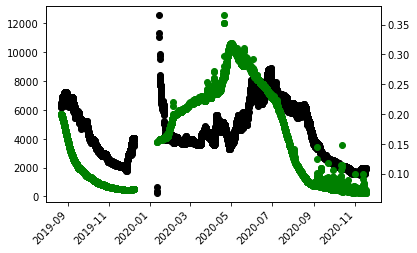

In [5]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df.index, df.soilCO2concentrationMean, c='k')
ax2.scatter(df.index, df.VSWCMean, c='g')
fig.autofmt_xdate(rotation=45)

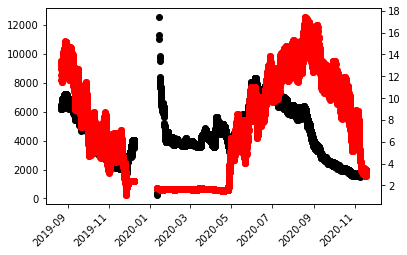

In [6]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df.index, df.soilCO2concentrationMean, c='k')
ax2.scatter(df.index, df.soilTempMean, c='r')
fig.autofmt_xdate(rotation=45)

Text(0.5, 0, 'CO2 (ppm?)')

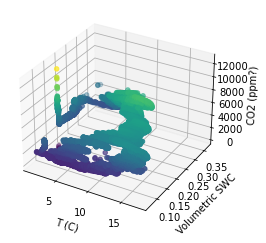

In [7]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x = df.soilTempMean
y = df.VSWCMean
z = df.soilCO2concentrationMean

ax.scatter(x, y, z, c=z)

ax.set_xlabel('T (C)')
ax.set_ylabel('Volumetric SWC')
ax.set_zlabel('CO2 (ppm?)')

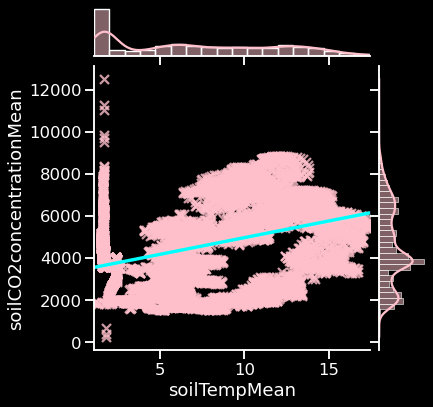

In [8]:
sns.set(style='ticks', context='talk')
plt.style.use('dark_background')
j = sns.jointplot(x='soilTempMean', y='soilCO2concentrationMean', data=df, kind = 'reg', color='pink', marker = 'x', joint_kws={'line_kws':{'color':'cyan'}})
# aack I wosh seabor would give us r and p!


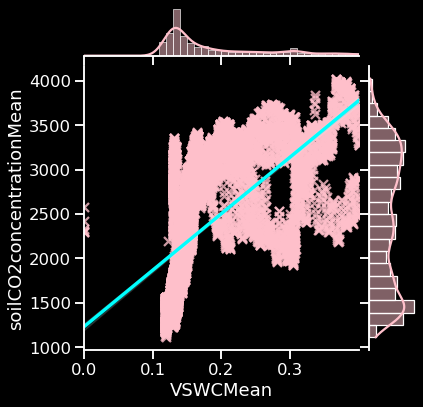

In [9]:
sns.set(style='ticks', context='talk')
plt.style.use('dark_background')
j = sns.jointplot(x='VSWCMean', y='soilCO2concentrationMean', data=df, kind = 'reg', color='pink', marker = 'x', joint_kws={'line_kws':{'color':'cyan'}})


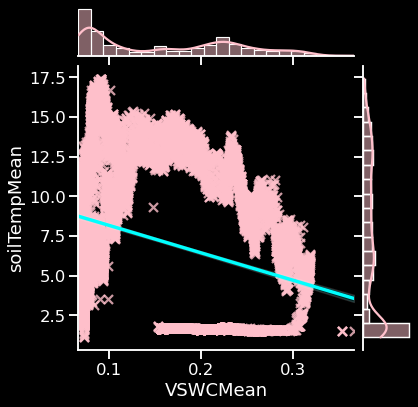

In [9]:
sns.set(style='ticks', context='talk')
plt.style.use('dark_background')
j = sns.jointplot(x='VSWCMean', y='soilTempMean', data=df, kind = 'reg', color='pink', marker = 'x', joint_kws={'line_kws':{'color':'cyan'}})


### 1) ###
Judging from all of these plots I think there might be a T sensor malfunction insome of the data. Also, double check the sensor positions to make sure the T ansd H2O sensors are lined up. Extract the actual z offset for each from the senor positions to report with each analysis.  Probably ultimately w will want to save a pdf for each sensor with graPHS AND STATISTICAL INFO.

### 2) ###

__a)__ For each dataset in the training sets split to train and validations sets.

__b)__ Create a model. validate.

__c)__ Validate on holdout sites.


In [12]:
import pandas as pd
import requests
import hashlib
import os
import glob

from dask import delayed
import dask
from dask.diagnostics import ProgressBar
from CO2xSWV import dload, make_df

In [13]:
?make_df

Signature: make_df(hor, ver, date, site, data_path)
Docstring:
Reads  NEON 1 minute cvs for:
       DP1.00094.001  (Soil CO2 concentrations)
       DP1.00041.001  (Soil Temperature)
       DP1.00095.001  (soil volumetric water content and salintiy)
   drops entries with bad finalQF flags,
   drops quality metric columns,
   and returns a delayed dataframe of merged data
   (use dask.compute() to make into pandas df).

Arguments:
hor  -- String - horizontal sensor position (HOR in the 
        NEON product readme files).
ver  -- String - vertical sensor position   (VER in the 
        NEON product readme files).
date -- String - month of data desired. (yyyy-mm)
site -- String - NOEN site code (e.g. 'BART')
data_path -- String - path to data.
File:      ~/CO2xSWV.py
Type:      function


In [18]:


def site_selection_stats(sites, products, data_path='./'):
    
    
    base_url = 'https://data.neonscience.org/api/v0/'
    data_path = data_path.rstrip('/')
    lazy = []
    
    for site in sites:
        # find dates for which all data products are available
        dates = get_common_dates(site, products, base_url)
        # get a list of  hours as yyyy-mm-dd hh:mm:ss which have data
        hours = viable_hours(site, products, base_url, dates) 
        
        
def viable_hours(site, products, base_url, dates, data_path):
    for product in products:
        for date in dates:
            dload(product, site, date, base_url, data_path)
            

            
            
            
def find_HOR_VER(site, data_path):
    # glob files for the site
    data_path='/home/jovyan/NEON/CO2xSWV_data'
    soil_CO2 = glob.glob(f'{data_path}/*{site}*SCO2C_1_minute*.csv')
    soil_H2O = glob.glob(f'{data_path}/*{site}*SWS_1_minute*.csv')
    soil_T   = glob.glob(f'{data_path}/*{site}*ST_1_minute*.csv')
    # make lists with date, and files for that date
    sc = set([f.split('.')[-4] for f in soil_CO2])
    sw = set([f.split('.')[-4] for f in soil_H2O])
    st = set([f.split('.')[-4] for f in soil_T])
    # find dates present in all data products
    dates = list(sc & sw & st)
    dates.sort()
    # make seperate lists of each product for the dates where all are present
    c = []
    w = []
    t = []
    for date in dates:
        c = c + [f for f in soil_CO2 if date in f]
        w = w + [f for f in soil_H2O if date in f]
        t = t + [f for f in soil_T if date in f]
    # Now we have all of the files for the site in seperate lists by product

    # find the HOR-VER combinations present for all dates at site
    horvers = []
    for date in dates:
        #find files for the date
        cc = [f for f in c if date in f]
        ww = [f for f in w if date in f]
        tt = [f for f in t if date in f]
        #find HOR and VER combinations for the date (e.g. '003501')
        ccc = [''.join(f.split('.')[6:8]) for f in cc]
        www = [''.join(f.split('.')[6:8]) for f in ww]
        ttt = [''.join(f.split('.')[6:8]) for f in tt]
        horver = list(set(ccc) & set(www) & set(ttt))
        horvers.append(horver)

    horver = set(horvers[0])   
    for hv in horvers[1:]:
        horver = horver & set(hv)
    horver = list(horver)

    hor = list(set([hv[:3] for hv in horver]))
    hor.sort()
    hor_ver = [[hv[:3], hv[3:]] for hv in horver]
    horver = {key : [] for key in hor}
    for key, val in hor_ver:
        horver[key].append(val)

    # horver is a dict all HOR-VER combinations available at  site
    # its like {Hor : [z1, z2,...]}
            
            
        
def get_common_dates(site, products, base_url):        
    dates_list = []
    for product in products:
        #this part determines which dates are available for the site/product
        url = f'{base_url}sites/{site}'
        response = requests.get(url)
        data = response.json()['data']
        dates = set(data['dataProducts'][0]['availableMonths'])
        dates_list.append(dates)
    dates = list(set.intersection(*dates_list))
    return(dates)
                     
                     
        

In [22]:
base_url = 'https://data.neonscience.org/api/v0/'
dates = []
for site in sitecodes:
    dates.append(get_common_dates(site, productcodes, base_url))
    

In [25]:
dates[1]


['2018-01',
 '2019-03',
 '2020-02',
 '2018-12',
 '2018-06',
 '2018-09',
 '2016-04',
 '2017-08',
 '2019-01',
 '2016-08',
 '2017-02',
 '2016-06',
 '2018-08',
 '2018-11',
 '2020-04',
 '2018-10',
 '2020-06',
 '2018-04',
 '2016-11',
 '2017-06',
 '2017-03',
 '2020-10',
 '2017-12',
 '2020-05',
 '2020-09',
 '2020-11',
 '2016-09',
 '2017-10',
 '2017-11',
 '2016-05',
 '2018-05',
 '2018-07',
 '2019-06',
 '2017-01',
 '2019-07',
 '2017-05',
 '2019-05',
 '2020-03',
 '2017-09',
 '2019-09',
 '2019-08',
 '2016-07',
 '2018-03',
 '2019-10',
 '2019-11',
 '2020-01',
 '2017-07',
 '2016-12',
 '2017-04',
 '2019-12',
 '2016-10',
 '2019-02',
 '2018-02',
 '2020-07',
 '2019-04',
 '2020-08']